# Add 2016 campaign data for fine-tuning

Data used for fine-tuning:

* corpus completo 5 temas - 08-sep-2016 - codificacion 5 temas.csv (competition)
* textos_de_los_tweets_en_campaña_2016.csv 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
from fastai.text import *
import html
import json

import pandas as pd
import numpy as np

pd.set_option('display.max_colwidth', -1)
np.set_printoptions(threshold=np.nan)


In [2]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

DATA_PATH=Path('./data/election_tweets')

DATA_PATH_0=Path('./data/tweets_2015_y_2016/tweets_2015_y_2016')

WIKILM_PATH=Path('./language_model_wiki/LM')

TWEETSLM_PATH=Path('./LM_tweets')

TWEETSLM_PATH_0=Path('./LM_tweets_0')

CLAS_PATH=Path('./tweets_class')

## Fintune 1.0

In [3]:
!ls {DATA_PATH_0}

textos_de_los_tweets_en_campaña_2016.csv
textos_de_los_tweets_en_precampaña_y_campaña_2015.csv


In [4]:
df = pd.read_csv(DATA_PATH_0/'textos_de_los_tweets_en_campaña_2016.csv',
                sep='delimiter', 
                header=None)

/home/andreas/anaconda3/envs/fastaiv07/lib/python3.6/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
tweets = df[0].values

In [6]:
def flattern(A):
    'Source: https://stackoverflow.com/a/17867797/7273299'
    
    'Flattens a list of lists and strings into a list.'
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flattern(i))
        else: rt.append(i)
    return rt

def isInt(v):
    'Source: https://stackoverflow.com/a/9859202/7273299'
    
    'Checks if a string is a number.'
    try:     i = int(v)
    except:  return False
    return True

def char_count(word, chars, lbound=2):
    char_count = [word.count(char) for char in chars]
    return all(i >= lbound for i in char_count)

def replace_lol(repl_str, texts):
    for string, chars in repl_str:
        texts = [[[string, i] if char_count(i, set(chars), 2) else i for i in text.split()] for text in texts]
        texts = np.array([flattern(text) for text in texts])
        texts = np.array([' '.join(text) for text in texts])
    return texts

def preprocess_tweets(tweets):
    """
    twitter specific text processing and shuffle
    """
    # Placeholders for hyperlinks and user references
    tweets = [['hyp_link' if i.startswith('http') 
               else 'user_ref' if i.startswith('@') 
               else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([' '.join(i) for i in tweets])

    # Prefix for Hashtags
    tweets = [[['hash_tag', i] if i.startswith('#') else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([flattern(tweet) for tweet in tweets])
    tweets = np.array([' '.join(i) for i in tweets])

    # Prefix for integers
    tweets = [[['int_string', i] if isInt(i) else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([flattern(tweet) for tweet in tweets])
    tweets = np.array([' '.join(i) for i in tweets])

    # Prefix for slang
    tweets = [[['que', 'slang_string'] if i=='q' else ['por', 'slang_string'] if i=='x' else ['de', 'slang_string'] if i=='d' else ['Que', 'slang_string'] if i=='Q' else ['Por', 'slang_string'] if i=='X' else ['De', 'slang_string'] if i=='D' else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([flattern(tweet) for tweet in tweets])
    tweets = np.array([' '.join(i) for i in tweets])

    # Lol type characters
    repl_str = [('risa_ja','ja'), ('risa_ji','ji'), ('risa_je','je'), ('risa_jo','jo'), ('risa_ju', 'ju')]

    # Adding prefix to lol type characters
    tweets = replace_lol(repl_str, tweets)

    #shuffle
    np.random.seed(42)
    trn_idx = np.random.permutation(len(tweets))
    tweets = tweets[trn_idx]
    
    return tweets



In [7]:
tweets = preprocess_tweets(tweets)

In [8]:
col_names = ['label', 'tweet']

In [9]:
print(tweets[:15])

['user_ref user_ref hombre, teniendo en cuenta que colaboró con FAES (PP), es como si hubiese ido con int_string 2 participaciones a un mismo debate.'
 'user_ref user_ref user_ref user_ref user_ref hyp_link'
 "user_ref user_ref user_ref user_ref En este minuto resume lo que debería ser en mi opinión la estrategia de C's."
 'user_ref mejor imposible! Xq los que slang_string quieren seguir en una democracia y no con un puño cerrado votarán seguro a user_ref hash_tag #Quedan5DiasM4'
 'Abre nueva charcutería en Madrid, con int_string 137 chorizos. hash_tag #EleccionesGenerales2016 hash_tag #26J hash_tag #26jTV3 hyp_link'
 "J'en appelle au peu de mes followers actifs svp vous pouvez faire juste int_string 10 rt pour que j'ai une nouvelle pp :3 hyp_link"
 'user_ref mi mas sentido pésame por sus resultados el int_string 26 J Esta vez si que vas a hacer historia....'
 'Politik &gt; Wali Kota Minta Pol PP Razia PSK di Kawasan Enggal hyp_link'
 'Es que hay que ser RETRASADO para meterse él solo 

In [10]:
train_limit = int(len(tweets)*0.8)

In [11]:
df_trn = pd.DataFrame({'tweet':tweets[:train_limit], 'label':[0]*len(tweets[:train_limit])}, columns=col_names)
df_val = pd.DataFrame({'tweet':tweets[train_limit:], 'label':[0]*len(tweets[train_limit:])}, columns=col_names)

In [12]:
df_trn.head()

,label,tweet
0,0,"user_ref user_ref hombre, teniendo en cuenta que colaboró con FAES (PP), es como si hubiese ido con int_string 2 participaciones a un mismo debate."
1,0,user_ref user_ref user_ref user_ref user_ref hyp_link
2,0,user_ref user_ref user_ref user_ref En este minuto resume lo que debería ser en mi opinión la estrategia de C's.
3,0,user_ref mejor imposible! Xq los que slang_string quieren seguir en una democracia y no con un puño cerrado votarán seguro a user_ref hash_tag #Quedan5DiasM4
4,0,"Abre nueva charcutería en Madrid, con int_string 137 chorizos. hash_tag #EleccionesGenerales2016 hash_tag #26J hash_tag #26jTV3 hyp_link"


In [13]:
df_trn.to_csv(TWEETSLM_PATH_0/'train.csv', header=False, index=False)
df_val.to_csv(TWEETSLM_PATH_0/'validation.csv', header=False, index=False)

In [14]:
df_trn.shape, df_val.shape

((2575909, 2), (643978, 2))

## Tokenize and Standarize


In [15]:
df_trn = pd.read_csv(TWEETSLM_PATH/'train.csv', header=None)
df_val = pd.read_csv(TWEETSLM_PATH/'validation.csv', header=None)
df_trn_0 = pd.read_csv(TWEETSLM_PATH_0/'train.csv', header=None)
df_val_0 = pd.read_csv(TWEETSLM_PATH_0/'validation.csv', header=None)

In [16]:
df_trn = df_trn.append(df_trn_0, ignore_index=True, verify_integrity=False, sort=None)
df_val = df_val.append(df_val_0, ignore_index=True, verify_integrity=False, sort=None)

In [17]:
df_trn.to_csv(TWEETSLM_PATH_0/'train_all.csv', header=False, index=False)
df_val.to_csv(TWEETSLM_PATH_0/'validation_all.csv', header=False, index=False)

In [18]:
chunksize=24000

re1 = re.compile(r'  +')

In [19]:
df_trn = pd.read_csv(TWEETSLM_PATH_0/'train_all.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(TWEETSLM_PATH_0/'validation_all.csv', header=None, chunksize=chunksize)

In [20]:
def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer(lang='es').proc_all_mp(partition_by_cores(texts), lang='es')
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
#     print(df)
    for i, r in enumerate(df):
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [21]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

In [22]:
len(tok_trn),len(trn_labels), len(tok_val), len(val_labels)

(2580317, 2580317, 645080, 645080)

In [23]:
print(tok_trn[:2])

[['\n', 'xbos', 'rt', 'user_ref', '.@albert_rivera', '"', 'c', "'s", 'está', 'en', 'todas', 'las', 'encuestas', 'por', 'delante', 'del', 't_up', 'psoe', ',', 'la', 'última', 'user_ref', 'hoy', '"', 'hash_tag', '#', '7deldebatedecisivo', 'hyp_link'], ['\n', 'xbos', 'rt', 'user_ref', 'rajoy', 'llamando', 'ley', 'mordaza', 'a', 'la', 'ley', 'mordaza', 'hash_tag', '#', 'l6ncallerajoy']]


In [24]:
(TWEETSLM_PATH_0/'tmp').mkdir(exist_ok=True)

In [25]:
np.save(TWEETSLM_PATH_0/'tmp'/'tok_trn.npy', tok_trn)
np.save(TWEETSLM_PATH_0/'tmp'/'tok_val.npy', tok_val)

In [26]:
tok_trn = np.load(TWEETSLM_PATH_0/'tmp'/'tok_trn.npy')
tok_val = np.load(TWEETSLM_PATH_0/'tmp'/'tok_val.npy')

In [27]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(20)

[('\n', 2580450),
 ('xbos', 2580317),
 ('user_ref', 1865782),
 ('t_up', 1464138),
 ('hyp_link', 1422605),
 ('de', 1288800),
 ('#', 1246050),
 ('hash_tag', 1217571),
 (',', 1074623),
 ('el', 1016295),
 ('que', 987853),
 ('.', 966595),
 ('a', 890927),
 ('pp', 806920),
 ('la', 790250),
 ('y', 687267),
 ('en', 588318),
 ('no', 531886),
 (':', 451791),
 ('"', 442335)]

In [28]:
max_vocab = 60000
min_freq = 2

In [29]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [30]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [31]:
np.save(TWEETSLM_PATH_0/'tmp'/'trn_ids.npy', trn_lm)
np.save(TWEETSLM_PATH_0/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(TWEETSLM_PATH_0/'tmp'/'itos.pkl', 'wb'))

## Load Encoder Weights for Language Model

In [32]:
BACKBONE_MODEL = WIKILM_PATH/'models/lm1_weights.h5'

In [33]:
wgts = torch.load(BACKBONE_MODEL, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target IMDB LM.

In [34]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [35]:
itos2 = pickle.load((WIKILM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

Before we try to transfer the knowledge from wikitext to the IMDB LM, we match up the vocab words and their indexes. We use the defaultdict container once again, to assign mean weights to unknown IMDB tokens that do not exist in wikitext103.

In [36]:
em_sz,nh,nl = 400,1150,3

In [37]:
trn_lm = np.load(TWEETSLM_PATH_0/'tmp'/'trn_ids.npy')
val_lm = np.load(TWEETSLM_PATH_0/'tmp'/'val_ids.npy')
itos = pickle.load(open(TWEETSLM_PATH_0/'tmp'/'itos.pkl', 'rb'))

In [38]:
vs=len(itos)
vs,len(trn_lm)

(60002, 2580317)

In [39]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

"We now overwrite the weights into the wgts odict. The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying."

In [40]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

## Language Model Finetuning

In [41]:
wd=1e-7
bptt=70
bs=64
em_sz,nh,nl = 400,1150,3
opt_fn = partial(optim.SGD, momentum=0.9)

In [42]:
trn_lm = np.load(TWEETSLM_PATH_0/'tmp'/'trn_ids.npy')
val_lm = np.load(TWEETSLM_PATH_0/'tmp'/'val_ids.npy')
trn_lm = np.concatenate(trn_lm)
val_lm = np.concatenate(val_lm)

In [43]:
itos = pickle.load(open(TWEETSLM_PATH_0/'tmp'/'itos.pkl', 'rb'))
vs = len(itos)

trn_dl = LanguageModelLoader(trn_lm, bs, bptt)
val_dl = LanguageModelLoader(val_lm, bs, bptt)
md = LanguageModelData(TWEETSLM_PATH_0, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [44]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [45]:
learn = md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learn.metrics = [accuracy]
learn.unfreeze()

In [46]:
learn.model.load_state_dict(wgts)

In [47]:
learn.lr_find2(start_lr=1e-1,end_lr=30, num_it=300)

  3%|▎         | 300/11919 [01:16<49:09,  3.94it/s, loss=4.79]

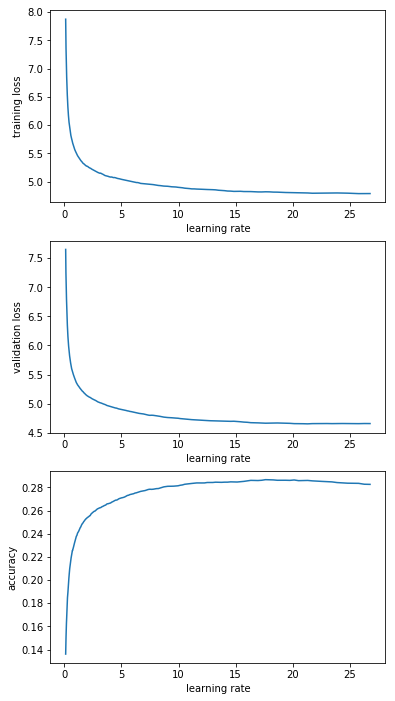

In [48]:
learn.sched.plot()

In [49]:
lr=6
lrs = lr

In [50]:
learn.clip=0.12

In [51]:
learn.fit(lr, 1, cycle_len=12, use_clr_beta=(10,33,0.95,0.85), best_save_name='lm1_wgts')

epoch      trn_loss   val_loss   accuracy   
    0      3.614272   3.454938   0.405962  
    1      3.404859   3.265676   0.427415  
    2      3.301455   3.179088   0.43673   
    3      3.258341   3.126856   0.442757  
    4      3.197711   3.084431   0.448024  
    5      3.154969   3.050926   0.452578  
    6      3.130731   3.018738   0.456677  
    7      3.056825   2.98355    0.461983  
    8      3.037361   2.965808   0.464635  
    9      3.025736   2.955874   0.46615   
    10     3.012072   2.947119   0.467577  
    11     3.002403   2.942431   0.468296  


[array([2.94243]), 0.46829589486112666]

In [52]:
learn.load('lm1_wgts')
learn.save_encoder('lm1_enc')

## Classifier tokens

In [53]:
chunksize=24000

re1 = re.compile(r'  +')

In [54]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'validation.csv', header=None, chunksize=chunksize)

In [55]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

In [56]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

In [57]:
np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

In [58]:
np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [59]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [60]:
itos = pickle.load((TWEETSLM_PATH_0/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [61]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [62]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

## Classifier

In [63]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [64]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [65]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [66]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In the classifier, unlike LM, we need to read a movie review at a time and learn to predict the it's sentiment as pos/neg. We do not deal with equal bptt size batches, so we have to pad the sequences to the same length in each batch. To create batches of similar sized movie reviews, we use a sortish sampler method invented by [@Smerity](https://twitter.com/Smerity) and [@jekbradbury](https://twitter.com/jekbradbury)

The sortishSampler cuts down the overall number of padding tokens the classifier ends up seeing.

In [67]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(TWEETSLM_PATH_0, trn_dl, val_dl)

In [68]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.8

In [69]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [70]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [71]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.12
learn.metrics = [accuracy]

In [72]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [73]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [74]:
wd = 1e-7
learn.load_encoder('lm1_enc')

In [75]:
learn.freeze_to(-1)

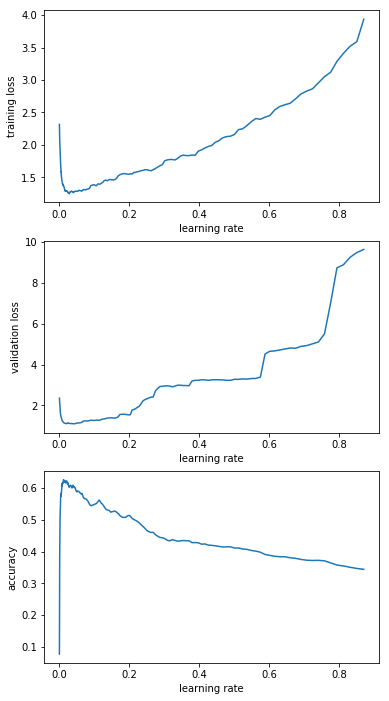

In [76]:
learn.lr_find2(start_lr=1e-3,end_lr=1, num_it=300)
learn.sched.plot()

In [77]:
learn.fit(lrs, 4, wds=wd, cycle_len=1, use_clr_beta=(32,10,0.8,0.7))

epoch      trn_loss   val_loss   accuracy   
    0      1.179151   0.86112    0.676925  
    1      1.044545   0.815255   0.692245  
    2      1.000866   0.79773    0.695428  
    3      1.008826   0.771303   0.702961  


[array([0.7713]), 0.7029608723640441]

In [78]:
learn.save('clas2_0')

In [79]:
learn.load('clas2_0')

In [80]:
learn.freeze_to(-2)

In [81]:
learn.fit(lrs, 4, wds=wd, cycle_len=1, use_clr_beta=(32,10,0.8,0.7))

epoch      trn_loss   val_loss   accuracy   
    0      0.950747   0.721621   0.745322  
    1      0.871949   0.678264   0.757188  
    2      0.892024   0.668242   0.755609  
    3      0.821759   0.624185   0.784022  


[array([0.62419]), 0.784021741771698]

In [82]:
learn.save('clas2_1')

In [83]:
learn.load('clas2_1')

In [84]:
learn.unfreeze()

In [85]:
learn.fit(lr, 1, cycle_len=8, use_clr_beta=(32,10,0.8,0.7), best_save_name='clas2')

epoch      trn_loss   val_loss   accuracy   
    0      0.716237   0.54136    0.811422  
    1      0.591019   0.422621   0.845622  
    2      0.493291   0.355901   0.874587  
    3      0.365642   0.353295   0.886003  
    4      0.280972   0.31977    0.89637   
    5      0.187051   0.36457    0.900003  
    6      0.142209   0.354106   0.91027   
    7      0.093983   0.349544   0.907303  


[array([0.34954]), 0.9073029067993164]

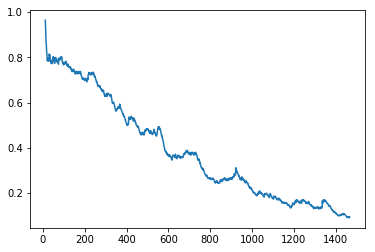

In [86]:
learn.sched.plot_loss()

In [88]:
learn.save("final")